# Flower Classification
The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.
For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
# Execute this to save new versions of the notebook
jovian.commit(project="neural-pro-3")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/krish-vadhani/neural-pro-3


'https://jovian.ai/krish-vadhani/neural-pro-3'

# all libraries

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split,DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

# Downloading Dataset

In [ ]:
dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'

In [ ]:
od.download(dataset_url)

Skipping, found downloaded files in "./flowers-recognition" (use force=True to force download)


In [ ]:
data_dir = './flowers-recognition/flowers'

In [ ]:
os.listdir(data_dir)

['daisy', 'tulip', 'rose', 'sunflower', 'dandelion']

In [ ]:
dataset = ImageFolder(data_dir,
                      tt.Compose([tt.ToTensor(),
                                  tt.Resize(150),
                                  tt.CenterCrop(150)]))

In [ ]:
len(dataset)

4317

# Loading Dataset

In [ ]:
train_size = int(0.8*(len(dataset)))
val_size = len(dataset) - train_size

In [ ]:
train_ds, val_ds = random_split(dataset,[train_size,val_size])

In [ ]:
batch_size = 64
train_dl = DataLoader(train_ds,batch_size,shuffle=True,num_workers=2,pin_memory=True)
val_dl = DataLoader(val_ds,shuffle=True,num_workers=2,pin_memory=True)

# EDA

In [ ]:
def show_image(img, label):
    plt.imshow(img.permute(1,2,0))
    print('Label:',dataset.classes[label])
    plt.axis('off')

Label: daisy


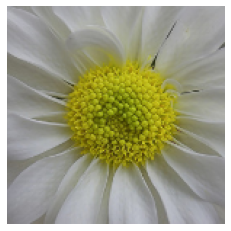

In [ ]:
show_image(*dataset[0])

Label: daisy


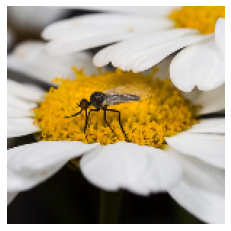

In [ ]:
show_image(*dataset[91])

Displaying the entire batch

In [ ]:
def show_batch(train_dl):
  for img, label in train_dl:
    plt.figure(figsize=(20,16))
    plt.imshow(make_grid(img, nrow=16).permute(1,2,0))
    plt.axis('off')
    break

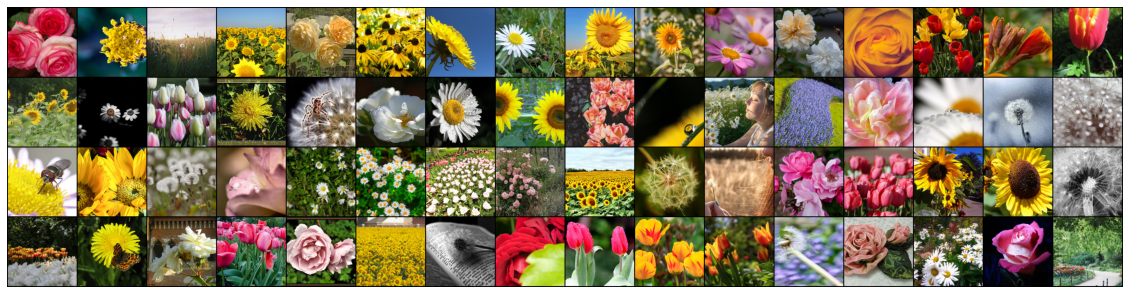

In [ ]:
show_batch(train_dl)

# Training the model

In [ ]:
class ImageClassificationBase(nn.Module):
  def training_step(self,batch):
    img, label = batch
    out = self(img)
    loss = F.cross_entropy(out,label)
    return loss

  def validation_step(self,batch):
    img, label = batch
    out = self(img)
    loss = F.cross_entropy(out,label)
    acc = accuracy(out,label)
    return {'val_loss':loss,'val_acc':acc}   

  def validation_epoch_end(self,out):
    val_loss = [x['val_loss'] for x in out]
    epoch_loss = torch.stack(val_loss).mean()

    val_acc = [x['val_acc'] for x in out]
    epoch_acc = torch.stack(val_acc).mean()
    return {'val_loss':epoch_loss, 'val_acc':epoch_acc}

  def epoch_end(self,epoch,result):
    print('Epoch:[{}],val_loss:{},val_acc:{},train_loss:{}'.format(epoch,result['val_loss'],result['val_acc'],result['train_loss']))

In [ ]:
def accuracy(out, label):
  _, pred = torch.max(out,dim=1)
  return torch.tensor(torch.sum(pred==label)/len(pred))

# Training the GPU

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

# Using Resnet Architecture

In [ ]:
class SimpleResnetModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,3,kernel_size=3,stride=1,padding=1)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(3,3,kernel_size=3,padding=1,stride=1)
    self.relu2 = nn.ReLU()

  def forward(self,x):
    out = self.conv1(x)
    out = self.relu1(out)
    out = self.conv2(x)
    out = self.relu2(out)
    return out + x    

In [ ]:
simple_resnet = to_device(SimpleResnetModel(),device)

for batch in train_dl:
  img, label = batch
  out = simple_resnet(img)
  print(out.shape)
  break

del img, label, simple_resnet

torch.cuda.empty_cache()

torch.Size([64, 3, 150, 150])


In [ ]:
def conv_block(in_channel,out_channel,pool=False):
  layers = [nn.Conv2d(in_channel,out_channel,kernel_size=3,padding=1,stride=1),
           nn.BatchNorm2d(out_channel),
           nn.ReLU(inplace=True)]


  if pool:
    layers.append(nn.MaxPool2d(2))

  return nn.Sequential(*layers)

In [ ]:
class Resnet9(ImageClassificationBase):
  def __init__(self,in_channel, num_classes):
    super().__init__()
    self.conv1 = conv_block(in_channel, 64)
    self.conv2 = conv_block(64,128,pool=True)
    self.res1 = nn.Sequential(conv_block(128,128),conv_block(128,128))

    self.conv3 = conv_block(128,256,pool=True)
    self.conv4 = conv_block(256,512,pool=True)
    self.res2 = nn.Sequential(conv_block(512,512),conv_block(512,512))

    self.classifier = nn.Sequential(
        nn.MaxPool2d(4),
        nn.Flatten(),
        nn.Dropout(0.2),
        nn.Linear(512*16,num_classes)
    )

  def forward(self,x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.res1(out) + out

    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out

    out = self.classifier(out)

    return out

In [ ]:
model = to_device(Resnet9(3,5),device)
model

Resnet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
@torch.no_grad()
def evaluate(model,val_dl):
  model.eval()
  out = [model.validation_step(batch) for batch in val_dl]
  return model.validation_epoch_end(out)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
def fit(epochs,model,max_lr,train_dl,val_dl,weight_decay=0,grad_clip=None,opt_func=torch.optim.Adam):
    optimizer = opt_func(model.parameters(),max_lr)
    history = []
    torch.cuda.empty_cache()

    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_dl))

    for epoch in range(epochs):
        train_loss = []
        model.train()
        lrs = []
        for batch in train_dl:
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            
            lrs.append(get_lr(optimizer))
            sched.step()

        result = evaluate(model,val_dl)
        result['train_loss'] = torch.stack(train_loss).mean()
        result['lrs'] = lrs
        model.epoch_end(epoch,result)
        history.append(result)

    return history

In [ ]:
hist = [evaluate(model, val_dl)]
hist

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


[{'val_acc': tensor(0.1944, device='cuda:0'),
  'val_loss': tensor(1.6097, device='cuda:0')}]

In [ ]:
epochs = 10
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam    

In [ ]:
hist += fit(epochs,model,1e-2,train_dl,val_dl,weight_decay=weight_decay,opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch:[0],val_loss:2.0946807861328125,val_acc:0.44328704476356506,train_loss:1.8354883193969727
Epoch:[1],val_loss:15.344372749328613,val_acc:0.25,train_loss:2.7542307376861572
Epoch:[2],val_loss:1.650006890296936,val_acc:0.47453704476356506,train_loss:2.9068942070007324
Epoch:[3],val_loss:1.1461807489395142,val_acc:0.6145833134651184,train_loss:1.5569143295288086
Epoch:[4],val_loss:1.1102086305618286,val_acc:0.5891203880310059,train_loss:1.1672463417053223
Epoch:[5],val_loss:0.9046247601509094,val_acc:0.6458333134651184,train_loss:0.9114317893981934
Epoch:[6],val_loss:0.8573238253593445,val_acc:0.6851851940155029,train_loss:0.8466189503669739
Epoch:[7],val_loss:0.7714180946350098,val_acc:0.694444477558136,train_loss:0.7379868030548096
Epoch:[8],val_loss:0.7231055498123169,val_acc:0.7175925970077515,train_loss:0.6498463749885559
Epoch:[9],val_loss:0.7057886719703674,val_acc:0.7233796119689941,train_loss:0.6014314889907837


In [ ]:
hist += fit(5,model,1e-4,train_dl,val_dl,weight_decay=weight_decay,opt_func=opt_func)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch:[0],val_loss:0.7044677138328552,val_acc:0.7291666865348816,train_loss:0.589958667755127
Epoch:[1],val_loss:0.6979880332946777,val_acc:0.7361111044883728,train_loss:0.5953818559646606
Epoch:[2],val_loss:0.6928707957267761,val_acc:0.7488425970077515,train_loss:0.5714616775512695
Epoch:[3],val_loss:0.691501259803772,val_acc:0.7384259104728699,train_loss:0.5601134300231934
Epoch:[4],val_loss:0.6950825452804565,val_acc:0.7418981790542603,train_loss:0.5461884140968323


In [ ]:
hist += fit(5,model,1e-4,train_dl,val_dl,weight_decay=weight_decay,opt_func=torch.optim.SGD)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch:[0],val_loss:0.6892744302749634,val_acc:0.7384259104728699,train_loss:0.5425621271133423
Epoch:[1],val_loss:0.6954478025436401,val_acc:0.7453703880310059,train_loss:0.5406501889228821
Epoch:[2],val_loss:0.6894164085388184,val_acc:0.7384259104728699,train_loss:0.5346936583518982
Epoch:[3],val_loss:0.6914159059524536,val_acc:0.7442129850387573,train_loss:0.5512259602546692
Epoch:[4],val_loss:0.6907069683074951,val_acc:0.7430555820465088,train_loss:0.5340334177017212
